# Cartesian Kerr-Schild Geodesic Integrator

This program is adapted from Dr. Chi-Kwan Chan's Kerr-Schild [geodesic integrator](https://github.com/rndsrc/bhrad/blob/main/5.geodesic.ipynb) for non-spinning black holes.

In [1]:
# We will use JAX for autodiff

from jax import numpy as np
from jax import jacfwd
from jax import jit
from jax.numpy        import dot
from jax.numpy.linalg import inv

from matplotlib import pyplot as plt

from tqdm import tqdm

## 1. The Cartesian Kerr-Schild coordinates

Thanks to autodiff, we only need to implement the metric for the Kerr-Schild coordinates $g_{\mu\nu}$. All other functions, such as the inverse metric $g^{\mu\nu}$ and the Jacobian of the metric $g_{\mu\nu,\alpha}$, can be computed automatically using JAX.

The Cartesian Kerr-Schild metric is expressed as follow, for indices (1, 2, 3, 4) representing (t, x, y, z):

$g_{\mu\nu} = η_{\mu\nu} + fl_{\mu}l_{\nu}$ 

$η_{\mu\nu}$ = diag(-1, 1, 1, 1) (Minkowski metric)

$f = \large{\frac{2r^3}{r^4 + a^4z^2}}$ (In dimensionless units, G = M = 1)

$\textbf{l} = (l_t, l_x, l_y, l_z) = (1, \large{\frac{rx+ay}{r^2+a^2}, \large{\frac{ry-ax}{r^2+a^2}}, \large{\frac{z}{r}}} \normalsize)$

r is implicitly defined by: $\large{\frac{x^2+y^2}{r^2+a^2}} \normalsize + \large{\frac{z^2}{r^2}}\normalsize = 1$

From the above equation, $r = \pm \frac{1}{\sqrt{2}} (\pm \sqrt{...})$. The only r that works for the Kerr-Schild metric is when both $\pm$ are pluses (written in full form in the code).

In [2]:
eta = np.asarray([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]) # Minkowski tensor

def metric(m):
    a = 1
    x = m[1]
    y = m[2]
    z = m[3]
    r = (1/np.sqrt(2))*(np.sqrt(-a**2 + np.sqrt(a**4 - 2*a**2*x**2 - 2*a**2*y**2 + 2*a**2*z**2 + x**4 + 2*x**2*y**2 + 2*x**2*z**2 + y**4 + 2*y**2*z**2 + z**4) + x**2 + y**2 + z**2))
    f = (2*r**3)/(r**4+a**2*z**2)
    l = np.asarray([1, (r*x+a*y)/(r**2+a**2), (r*y-a*x)/(r**2+a**2), z/r])
    return eta + f * l[:,np.newaxis] * l[np.newaxis,:] 

def imetric(x):
    return inv(metric(x))

dmetric = jacfwd(metric)

## 2. Runge-Kutta-Fehlberg 4(5) method

Because the 4th-order Runge-Kutta method is unstable in integrating geodesics inside the event horizon due to large step sizes, the Runge-Kutta-Fehlberg 4(5) adaptive stepsize control with [Cash-Karp](https://dl.acm.org/doi/10.1145/79505.79507) parameters is implemented. For more reference on this method, read [Numerical Recipes for C](https://people.cs.clemson.edu/~dhouse/courses/817/papers/adaptive-h-c16-2.pdf).

In [3]:
def RKF45(rhs, state, dt, epsilon):
    
    t = state[0]
    k1 = dt * rhs(state, t)
    k2 = dt * rhs(state + 1/5 * k1, t + 1/5 * dt)
    k3 = dt * rhs(state + 3/40 * k1 + 9/40 * k2, t + 3/10 * dt)
    k4 = dt * rhs(state + 3/10 * k1 - 9/10 * k2 + 6/5 * k3, t + 3/5 * dt)
    k5 = dt * rhs(state - 11/54 * k1 + 5/2 * k2 - 70/27 * k3 + 35/27 * k4, t + dt)
    k6 = dt * rhs(state + 1631/55296 * k1 + 175/512 * k2 + 575/13824 * k3 + 44275/110592 * k4 + 253/4096 * k5, t + 7/8 * dt)
    
    # Embedded 4th order
    state4 = state + 2825/27643 * k1 + 18575/48384 * k3 + 13525/55296 * k4 - 277/14336 * k5 + 1/4 * k6
    
    # 5th order
    state5 = state + 37/378 * k1 + 250/621 * k3 + 125/594 * k4 + 512/1771 * k6
    
    R = np.linalg.norm(state5 - state4) # Truncation error
    
    multiplier = 0.9*(epsilon/R)**1/4 
    
    # If the truncation error is small, return the 4th order estimation and update the stepsize
    if R <= epsilon:
        dt = dt * multiplier
        return state4
    # If the truncation error is big, repeat the process with a smaller stepsize
    else:
        return RKF45(rhs, state, dt * multiplier, epsilon)

## 3. The Geodesic Equation

The geodesic equation is expressed in the form derived by this [paper](https://iopscience.iop.org/article/10.3847/1538-4357/aadfe5/meta).

In [4]:
def rhs(state, t):
    x  = np.append(t, state[1:4])
    v  = state[4:]
    
    ig = imetric(x)
    jg = dmetric(x)
    a  = (-       dot(ig, dot(dot(jg, v), v))
          + 0.5 * dot(ig, dot(v, dot(v, jg))))
    
    return np.concatenate([v, a])

# 4.1. a = 1, initial trajectory is parallel to the ring singularity

### 4.1.1. Sending photons directly into the event horizon

In [5]:
dt = 0.05 # Step size
N  = 1000 # Number of integration steps
s0 = np.array([
    0, 5, 0.5, 1,
    1, -1, 0, 0,
], dtype=np.float32) # Initial conditions

# Construct the array to hold the results

states = [s0]

# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RKF45(rhs, states[-1], dt, 0.1))
    
S = np.array(states)
X = S[:,:4]
V = S[:,4:]
a = 1

100%|██████████| 1000/1000 [18:03<00:00,  1.08s/it]


**Color notation**: photon trajectory (orange), outer event horizon (red), outer ergosphere (blue), ring singularity (red)

XY-PLANE PLOT:

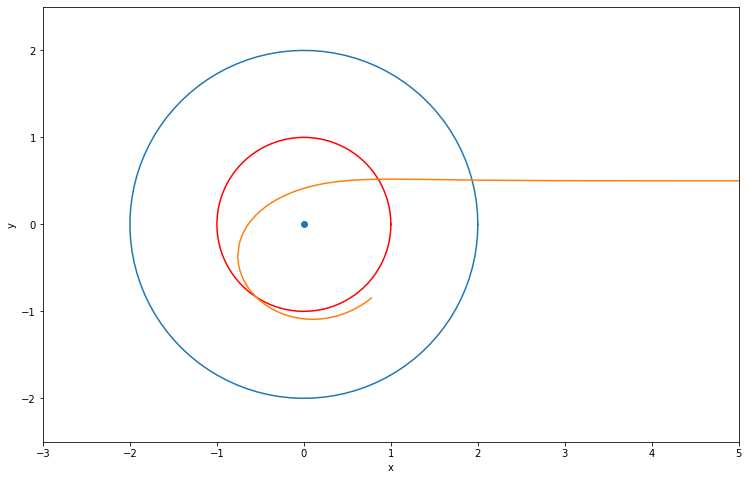

In [41]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1) # theta = pi/2 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.cos(phi), a * np.sin(phi), color='r') # outer event horizon = ring singularity
ax.plot(e_outer * np.cos(phi), e_outer * np.sin(phi)) # outer ergosphere
ax.plot(X[:,1], X[:,2])
ax.set_xlim(-3, 5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(0,0)
ax.set_aspect('equal')

XZ-PLANE PLOT:

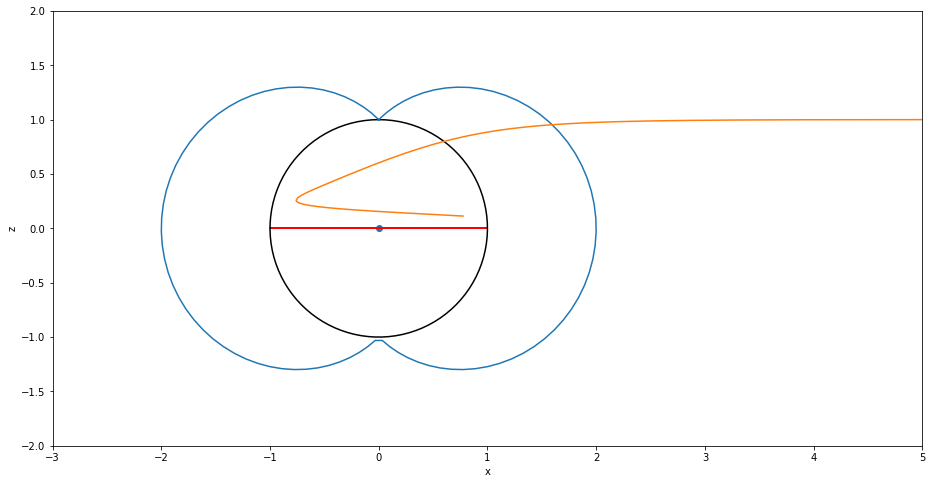

In [51]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = 0 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.cos(phi), np.zeros(phi.size), color='r') # ring singularity
ax.plot(r_outer * np.sin(theta), r_outer * np.cos(theta), color = 'black') # outer event horizon
ax.plot(e_outer * np.sin(theta), e_outer * np.cos(theta)) # outer ergosphere
ax.plot(X[:,1], X[:,3])
ax.set_xlim(-3, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel("x")
ax.set_ylabel("z")
plt.scatter(0,0)
ax.set_aspect('equal')

YZ-PLANE PLOT:

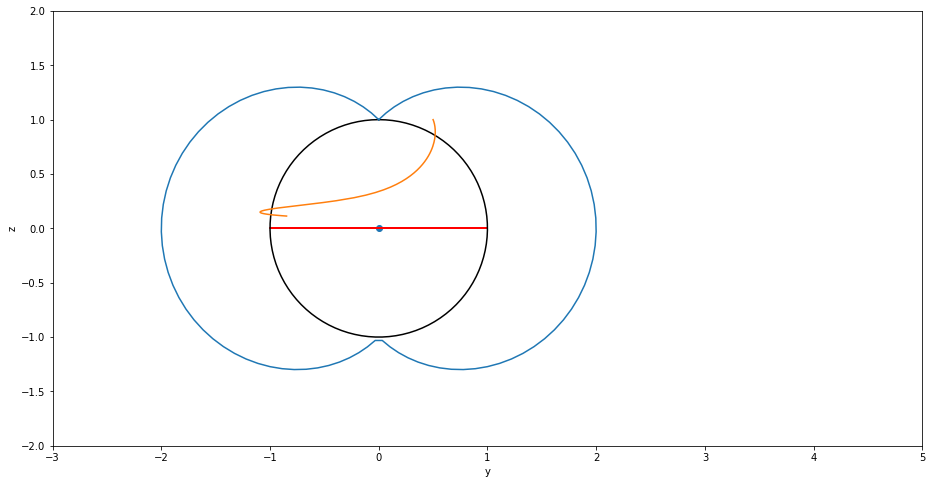

In [52]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = 0 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.sin(phi), np.zeros(phi.size), color='r') # ring singularity
ax.plot(r_outer * np.sin(theta), r_outer * np.cos(theta), color = 'black') # outer event horizon
ax.plot(e_outer * np.sin(theta), e_outer * np.cos(theta)) # outer ergosphere
ax.plot(X[:,2], X[:,3])
ax.set_xlim(-3, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel("y")
ax.set_ylabel("z")
plt.scatter(0,0)
ax.set_aspect('equal')

3D PLOT:

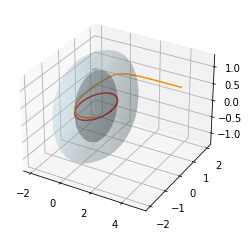

In [61]:
phi = np.linspace(0, 2 * np.pi, 32)
theta = np.linspace(0, np.pi, 32)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = pi/2 for middle xy-plane cross-section of ergosphere

def sphere(r, color, alpha):
    x = r * np.outer(np.cos(phi), np.sin(theta))
    y = r * np.outer(np.sin(phi), np.sin(theta))
    z = r * np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax.plot_surface(x, y, z, color = color, alpha = alpha)
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot3D(a*np.cos(phi), a*np.sin(phi), np.zeros(phi.size), color = "red") # ring singularity
ax.plot3D(X[:, 1], X[:, 2], X[:, 3], color = "darkorange")
sphere(r_outer, "black", 0.2) # outer event horizon
sphere(e_outer, "lightblue", 0.2) # outer ergosphere

Comment: When the photon is beamed directly into the outer event horizon, it has to encounter regions in the vicinity of the ring singularity early because the outer event horizon's radius coincides with the ring singularity's radius. As a result, the photon's motion slows down very quickly as the numerical algorithm takes very small dt to handle the unstability surrounding the singularity.

### 4.1.2. Sending photons directly into the ergosphere

In [62]:
dt = 0.05 # Step size
N  = 1000 # Number of integration steps
s0 = np.array([
    0, 5, 1.2, 1.2,
    1, -1, 0, 0,
], dtype=np.float32) # Initial conditions

# Construct the array to hold the results

states = [s0]

# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RKF45(rhs, states[-1], dt, 0.1))
    
S = np.array(states)
X = S[:,:4]
V = S[:,4:]
a = 1

100%|██████████| 1000/1000 [19:37<00:00,  1.18s/it]


XY-PLANE PLOT:

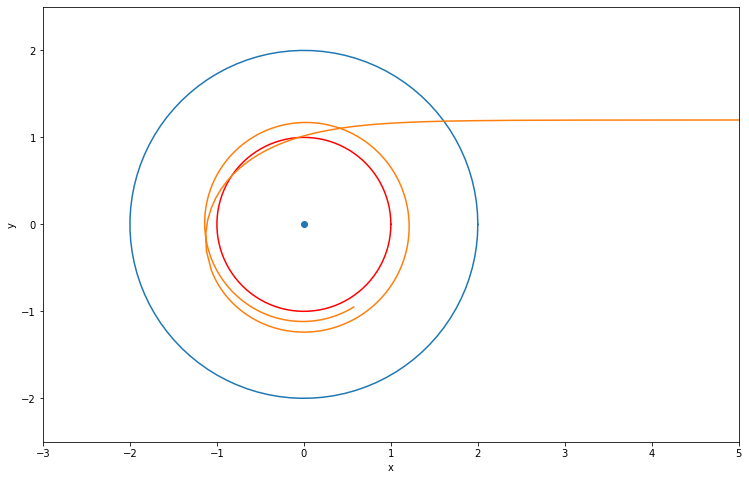

In [63]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1) # theta = pi/2 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.cos(phi), a * np.sin(phi), color='r') # outer event horizon = ring singularity
ax.plot(e_outer * np.cos(phi), e_outer * np.sin(phi)) # outer ergosphere
ax.plot(X[:,1], X[:,2])
ax.set_xlim(-3, 5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(0,0)
ax.set_aspect('equal')

XZ-PLANE PLOT:

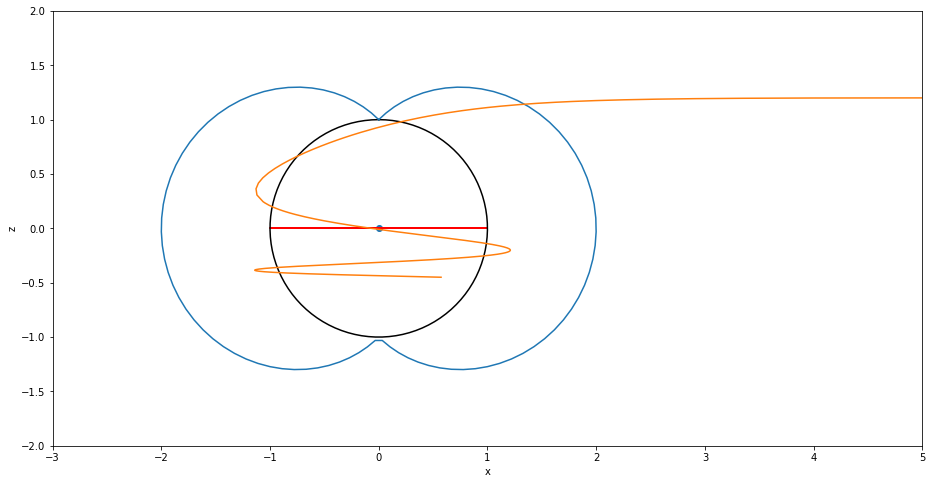

In [64]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = 0 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.cos(phi), np.zeros(phi.size), color='r') # ring singularity
ax.plot(r_outer * np.sin(theta), r_outer * np.cos(theta), color = 'black') # outer event horizon
ax.plot(e_outer * np.sin(theta), e_outer * np.cos(theta)) # outer ergosphere
ax.plot(X[:,1], X[:,3])
ax.set_xlim(-3, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel("x")
ax.set_ylabel("z")
plt.scatter(0,0)
ax.set_aspect('equal')

YZ-PLANE PLOT:

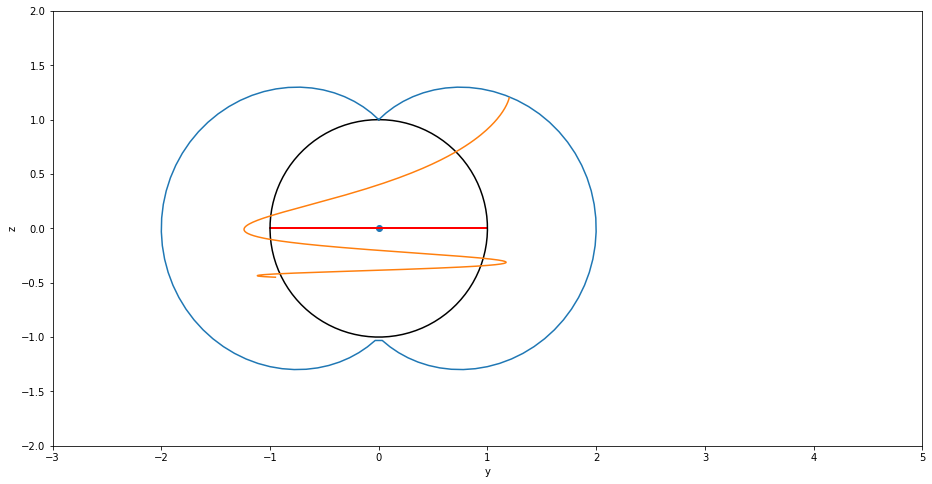

In [65]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = 0 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.sin(phi), np.zeros(phi.size), color='r') # ring singularity
ax.plot(r_outer * np.sin(theta), r_outer * np.cos(theta), color = 'black') # outer event horizon
ax.plot(e_outer * np.sin(theta), e_outer * np.cos(theta)) # outer ergosphere
ax.plot(X[:,2], X[:,3])
ax.set_xlim(-3, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel("y")
ax.set_ylabel("z")
plt.scatter(0,0)
ax.set_aspect('equal')

3D PLOT:

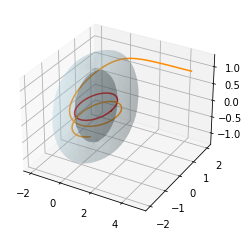

In [66]:
phi = np.linspace(0, 2 * np.pi, 32)
theta = np.linspace(0, np.pi, 32)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = pi/2 for middle xy-plane cross-section of ergosphere

def sphere(r, color, alpha):
    x = r * np.outer(np.cos(phi), np.sin(theta))
    y = r * np.outer(np.sin(phi), np.sin(theta))
    z = r * np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax.plot_surface(x, y, z, color = color, alpha = alpha)
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot3D(a*np.cos(phi), a*np.sin(phi), np.zeros(phi.size), color = "red") # ring singularity
ax.plot3D(X[:, 1], X[:, 2], X[:, 3], color = "darkorange")
sphere(r_outer, "black", 0.2) # outer event horizon
sphere(e_outer, "lightblue", 0.2) # outer ergosphere

Comment: In contrast to the previous case, as the photon is not beamed directly into the event horizon, it travels more within the same integration steps. Also, as soon as it enters the ergosphere, it experiences strong frame dragging and travels along the black hole's rotational orientation as expected.

### 4.1.3 Sending photons to outside the ergosphere

In [67]:
dt = 0.05 # Step size
N  = 1000 # Number of integration steps
s0 = np.array([
    0, 5, 1.5, 2.01,
    1, -1, 0, 0,
], dtype=np.float32) # Initial conditions

# Construct the array to hold the results

states = [s0]

# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RKF45(rhs, states[-1], dt, 0.1))
    
S = np.array(states)
X = S[:,:4]
V = S[:,4:]
a = 1

100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s]


XY-PLANE PLOT:

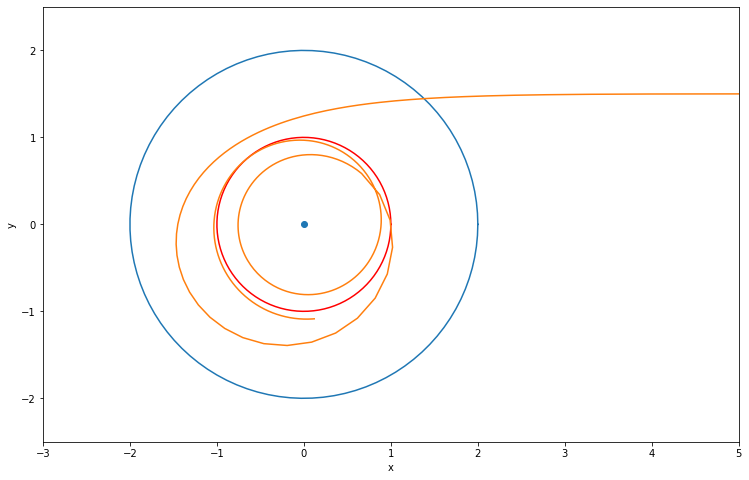

In [69]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1) # theta = pi/2 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.cos(phi), a * np.sin(phi), color='r') # outer event horizon = ring singularity
ax.plot(e_outer * np.cos(phi), e_outer * np.sin(phi)) # outer ergosphere
ax.plot(X[:,1], X[:,2])
ax.set_xlim(-3, 5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(0,0)
ax.set_aspect('equal')

XZ-PLANE PLOT:

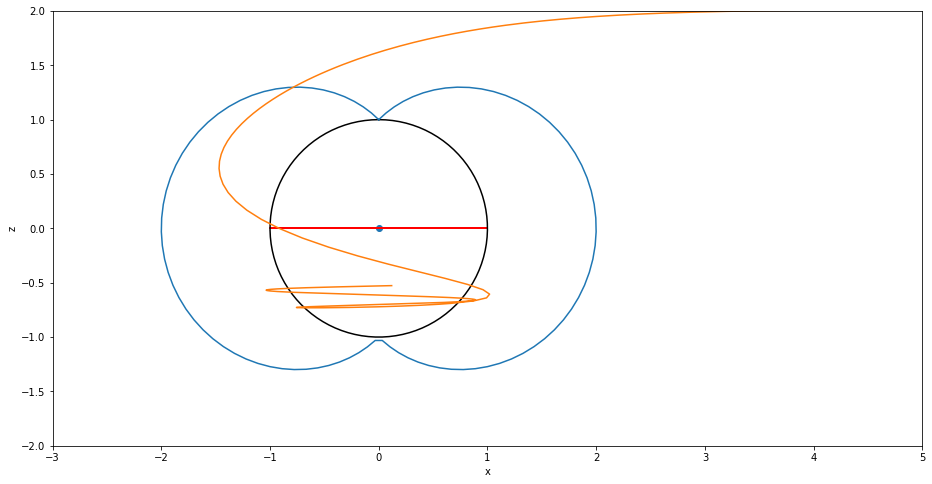

In [70]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = 0 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.cos(phi), np.zeros(phi.size), color='r') # ring singularity
ax.plot(r_outer * np.sin(theta), r_outer * np.cos(theta), color = 'black') # outer event horizon
ax.plot(e_outer * np.sin(theta), e_outer * np.cos(theta)) # outer ergosphere
ax.plot(X[:,1], X[:,3])
ax.set_xlim(-3, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel("x")
ax.set_ylabel("z")
plt.scatter(0,0)
ax.set_aspect('equal')

YZ-PLANE PLOT:

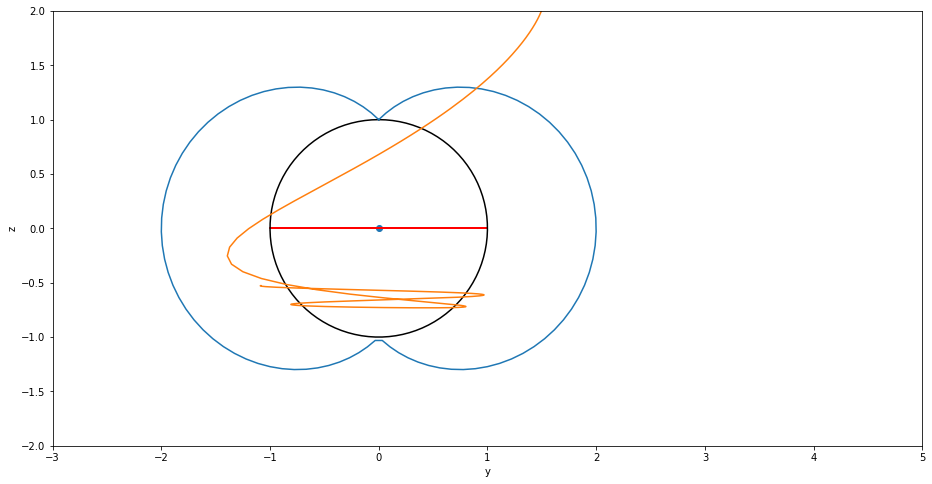

In [71]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = 0 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.sin(phi), np.zeros(phi.size), color='r') # ring singularity
ax.plot(r_outer * np.sin(theta), r_outer * np.cos(theta), color = 'black') # outer event horizon
ax.plot(e_outer * np.sin(theta), e_outer * np.cos(theta)) # outer ergosphere
ax.plot(X[:,2], X[:,3])
ax.set_xlim(-3, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel("y")
ax.set_ylabel("z")
plt.scatter(0,0)
ax.set_aspect('equal')

3D PLOT:

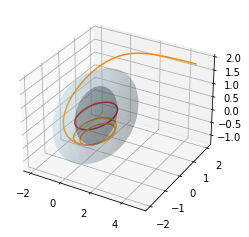

In [73]:
phi = np.linspace(0, 2 * np.pi, 32)
theta = np.linspace(0, np.pi, 32)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = pi/2 for middle xy-plane cross-section of ergosphere

def sphere(r, color, alpha):
    x = r * np.outer(np.cos(phi), np.sin(theta))
    y = r * np.outer(np.sin(phi), np.sin(theta))
    z = r * np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax.plot_surface(x, y, z, color = color, alpha = alpha)
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot3D(a*np.cos(phi), a*np.sin(phi), np.zeros(phi.size), color = "red") # ring singularity
ax.plot3D(X[:, 1], X[:, 2], X[:, 3], color = "darkorange")
sphere(r_outer, "black", 0.2) # outer event horizon
sphere(e_outer, "lightblue", 0.2) # outer ergosphere

Comment: Like the previous case, the photon avoids the ring singularity and moves to the bottom of the black hole. There appears to be centrifugal force of the rotating ring singularity that expels the photon from the ring singularity. The photon also experiences strong frame dragging. Because the photon is not beaming directly into the ergosphere, it travels longer due to the numerical stability of the environment slightly further away from the ring singularity compared to the previous cases.

## 4.2. a = 1, initial trajectory is 45o above the ring singularity

In [5]:
dt = 0.05 # Step size
N  = 5000 # Number of integration steps
s0 = np.array([
    0, 5, 0.5, 5,
    1, -1, 0, -1,
], dtype=np.float32) # Initial conditions

# Construct the array to hold the results

states = [s0]

# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RKF45(rhs, states[-1], dt, 1))
    
S = np.array(states)
X = S[:,:4]
V = S[:,4:]
a = 1

100%|██████████| 5000/5000 [1:43:11<00:00,  1.24s/it]  


XY-PLANE PLOT:

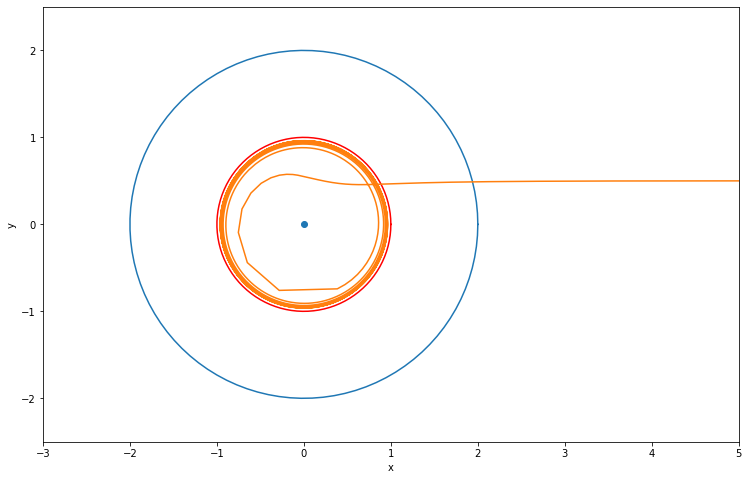

In [6]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1) # theta = pi/2 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.cos(phi), a * np.sin(phi), color='r') # outer event horizon = ring singularity
ax.plot(e_outer * np.cos(phi), e_outer * np.sin(phi)) # outer ergosphere
ax.plot(X[:,1], X[:,2])
ax.set_xlim(-3, 5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(0,0)
ax.set_aspect('equal')

XZ-PLANE PLOT:

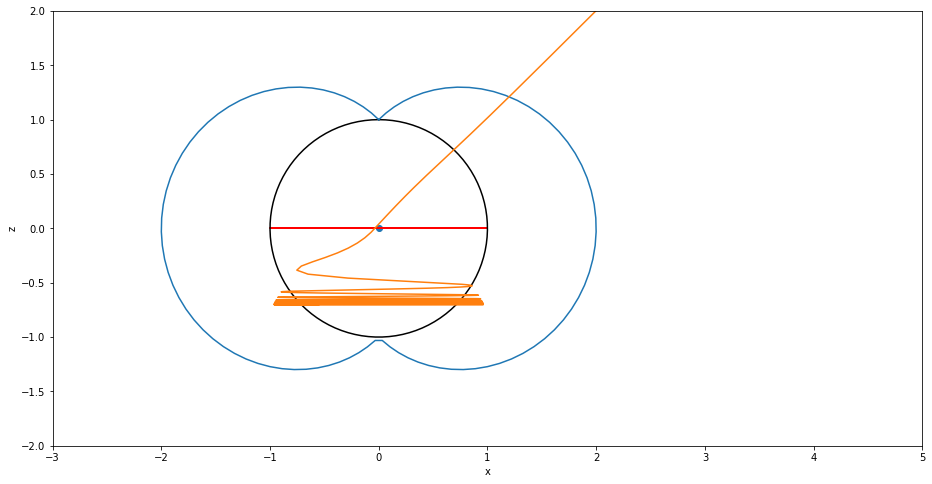

In [7]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = 0 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.cos(phi), np.zeros(phi.size), color='r') # ring singularity
ax.plot(r_outer * np.sin(theta), r_outer * np.cos(theta), color = 'black') # outer event horizon
ax.plot(e_outer * np.sin(theta), e_outer * np.cos(theta)) # outer ergosphere
ax.plot(X[:,1], X[:,3])
ax.set_xlim(-3, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel("x")
ax.set_ylabel("z")
plt.scatter(0,0)
ax.set_aspect('equal')

YZ-PLANE PLOT:

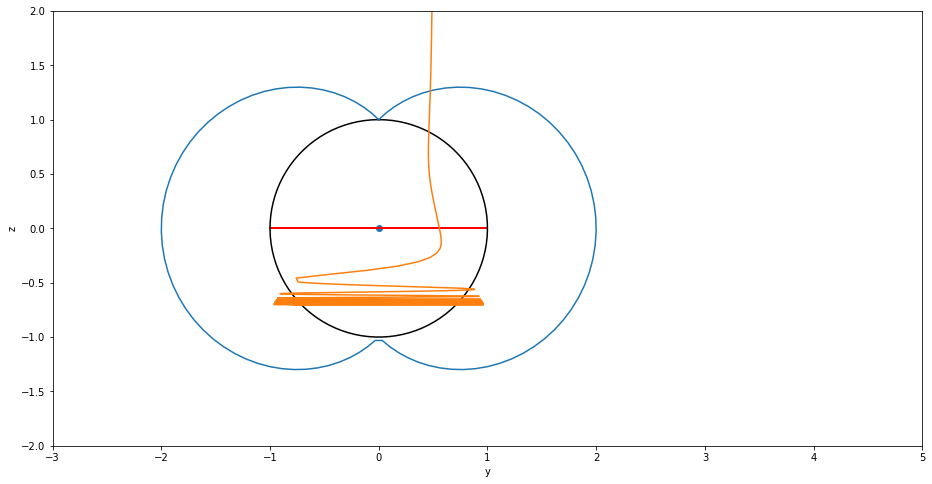

In [8]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = 0 for middle xy-plane cross-section of ergosphere

ax.plot(a * np.sin(phi), np.zeros(phi.size), color='r') # ring singularity
ax.plot(r_outer * np.sin(theta), r_outer * np.cos(theta), color = 'black') # outer event horizon
ax.plot(e_outer * np.sin(theta), e_outer * np.cos(theta)) # outer ergosphere
ax.plot(X[:,2], X[:,3])
ax.set_xlim(-3, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel("y")
ax.set_ylabel("z")
plt.scatter(0,0)
ax.set_aspect('equal')

3D PLOT:

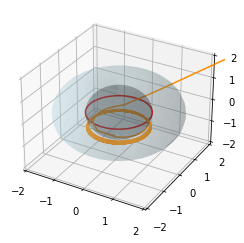

In [9]:
phi = np.linspace(0, 2 * np.pi, 32)
theta = np.linspace(0, np.pi, 32)
r_outer = 1 + np.sqrt(1-a**2)
e_outer = 1 + np.sqrt(1-a**2*(np.cos(theta))**2) # phi = pi/2 for middle xy-plane cross-section of ergosphere

def sphere(r, color, alpha):
    x = r * np.outer(np.cos(phi), np.sin(theta))
    y = r * np.outer(np.sin(phi), np.sin(theta))
    z = r * np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax.plot_surface(x, y, z, color = color, alpha = alpha)
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot3D(a*np.cos(phi), a*np.sin(phi), np.zeros(phi.size), color = "red") # ring singularity
ax.plot3D(X[:, 1], X[:, 2], X[:, 3], color = "darkorange")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
sphere(r_outer, "black", 0.2) # outer event horizon
sphere(e_outer, "lightblue", 0.2) # outer ergosphere

<img src="Desktop/plot 1.png">

Comment: The photon travels directly into the ring singularity and descends to the bottom quarter of the black hole where it spins accordingly to the frame dragging effects. Its orbital period shrinks, and its orbital size remains enclosed within the ring singularity. The orbits seem to occur outside the outer event horizon sphere although the photon enters the event horizon earlier. 

## 4.3. Frame Dragging